In [ ]:
# !pip install qiskit qiskit-aer mthree matplotlib numpy

In [67]:
import numpy as np
from qiskit import QuantumCircuit, transpile 
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from mthree import M3Mitigation
import matplotlib.pyplot as plt
import warnings
import mthree
from random import choice  
warnings.filterwarnings('ignore')

# Noise Model and Error Mitigation
Thiscode demonstrates how to:
1. Create a quantum circuit implementing a GHZ state
2. Add realistic noise to the circuit simulation using Qiskit's noise model
   - Depolarizing errors on single and two-qubit gates
   - Thermal relaxation errors on measurements
3. Run the noisy circuit simulation
4. Apply error mitigation using M3 (Matrix-free Measurement Mitigation)
5. Compare the results between:
   - Raw noisy measurements
   - Error-mitigated measurements  
   - Ideal (noise-free) expected probabilities


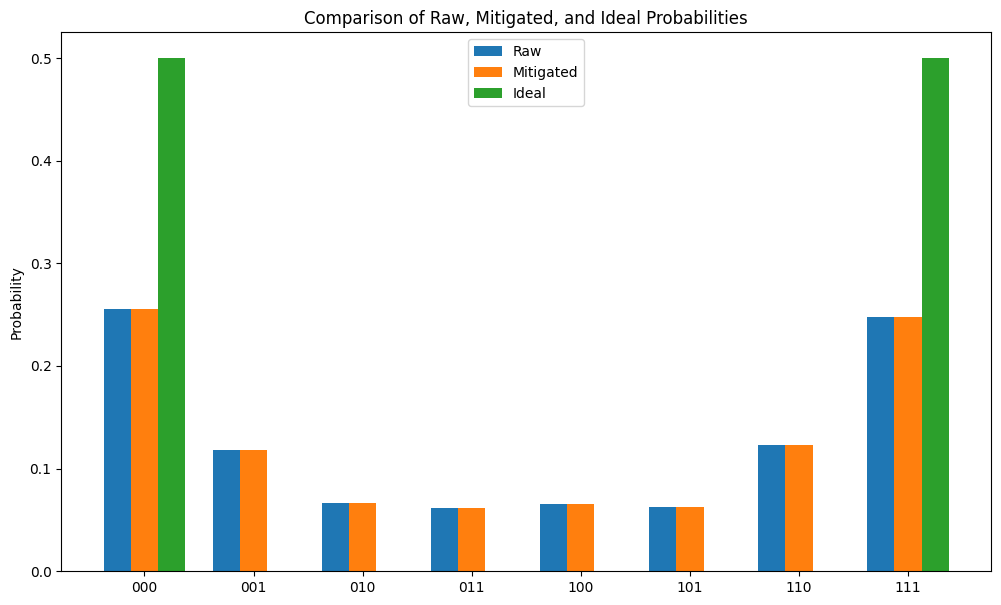

KL Divergence (Raw vs Ideal): 9.9020
KL Divergence (Mitigated vs Ideal): 9.9020
Mitigation did not significantly improve the accuracy. Consider tuning noise model or calibration.


In [68]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()

noise_model = NoiseModel()
depolarizing = depolarizing_error(0.3, 1)
depolarizing_cx = depolarizing_error(0.5, 2)
thermal = thermal_relaxation_error(100e-6, 150e-6, 1e-6)

noise_model.add_all_qubit_quantum_error(depolarizing, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_cx, ['cx'])
noise_model.add_all_qubit_quantum_error(thermal, ['measure'])

backend = Aer.get_backend('qasm_simulator')

transpiled_qc = transpile(qc, backend)
result = backend.run(transpiled_qc, noise_model=noise_model, shots=5000).result()
raw_counts = result.get_counts()

mit = mthree.M3Mitigation(backend)
mit.cals_from_system(range(3))
mitigated_result = mit.apply_correction(raw_counts, range(3))
mitigated_counts = mitigated_result.nearest_probability_distribution()

all_keys = sorted(set(raw_counts.keys()) | set(mitigated_counts.keys()))
total_shots = sum(raw_counts.values())
raw_probs = {key: count / total_shots for key, count in raw_counts.items()}

ideal_probs = {"000": 0.5, "111": 0.5}
for key in all_keys:
    if key not in ideal_probs:
        ideal_probs[key] = 0

x = np.arange(len(all_keys))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(x - width, [raw_probs.get(key, 0) for key in all_keys], width, label='Raw')
ax.bar(x, [mitigated_counts.get(key, 0) for key in all_keys], width, label='Mitigated')
ax.bar(x + width, [ideal_probs.get(key, 0) for key in all_keys], width, label='Ideal')

ax.set_ylabel('Probability')
ax.set_title('Comparison of Raw, Mitigated, and Ideal Probabilities')
ax.set_xticks(x)
ax.set_xticklabels(all_keys)
ax.legend()

plt.show()

def kl_divergence(p, q):
    epsilon = 1e-10
    keys = set(p.keys()).union(set(q.keys()))
    p_vals = np.array([p.get(k, 0) + epsilon for k in keys])
    q_vals = np.array([q.get(k, 0) + epsilon for k in keys])
    return np.sum(p_vals * np.log(p_vals / q_vals))

kl_raw_ideal = kl_divergence(raw_probs, ideal_probs)
kl_mitigated_ideal = kl_divergence(mitigated_counts, ideal_probs)

print(f"KL Divergence (Raw vs Ideal): {kl_raw_ideal:.4f}")
print(f"KL Divergence (Mitigated vs Ideal): {kl_mitigated_ideal:.4f}")

if kl_mitigated_ideal < kl_raw_ideal:
    print("Mitigation reduced the divergence, indicating it improved accuracy.")
else:
    print("Mitigation did not significantly improve the accuracy. Consider tuning noise model or calibration.")


# Dynamical Decoupling Implementation and Noise Model Analysis

In this section, we implement dynamical decoupling (DD) sequences and analyze their effectiveness in mitigating noise. The code below includes:

1. Standard Circuit Creation:
   - Creates a basic quantum circuit with Hadamard and CNOT gates
   - Includes measurement operations

2. Dynamical Decoupling Circuit:
   - Implements the XY4 sequence between quantum operations
   - XY4 sequence consists of X and Y pulses to reduce decoherence
   
3. Noise Model:
   - Includes depolarizing errors for single and two-qubit gates
   - Incorporates thermal relaxation effects
   - Customizable error rates and parameters

4. Simulation Functions:
   - Enables comparison between standard and DD-protected circuits
   - Uses Qiskit's QASM simulator with noise model

The following cells demonstrate the implementation and analysis of these components.


Standard Circuit Counts: {'000': 407, '111': 389, '110': 69, '001': 67, '011': 19, '100': 25, '101': 23, '010': 25}
DD-Enhanced Circuit Counts: {'111': 403, '000': 387, '100': 22, '001': 74, '101': 25, '011': 21, '110': 68, '010': 24}


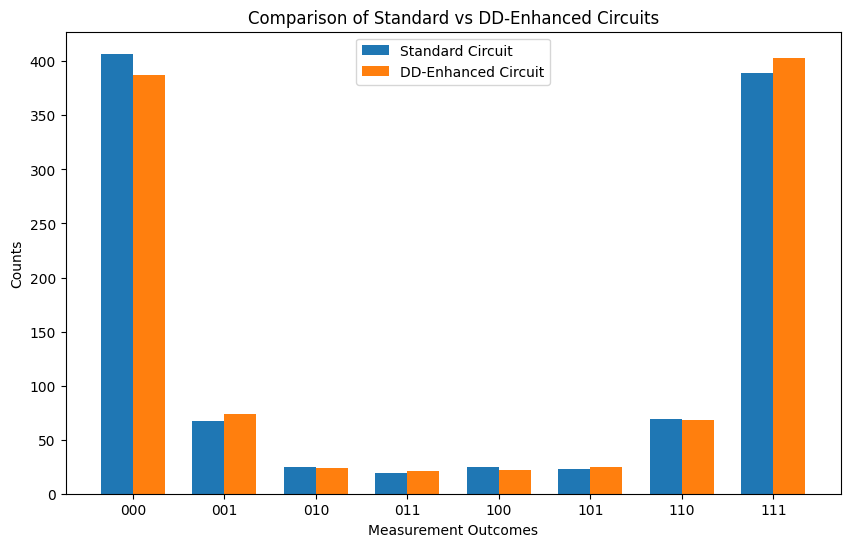

In [69]:
def create_standard_circuit():
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.measure([0,1,2], [0,1,2])
    return qc

def create_dd_circuit(dd_sequence='XY4'):
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    apply_dynamical_decoupling(qc, qubits=[0,1,2], sequence=dd_sequence)
    qc.cx(0, 1)
    apply_dynamical_decoupling(qc, qubits=[0,1,2], sequence=dd_sequence)
    qc.cx(1, 2)
    apply_dynamical_decoupling(qc, qubits=[0,1,2], sequence=dd_sequence)
    qc.measure([0,1,2], [0,1,2])
    return qc

def apply_dynamical_decoupling(qc, qubits, sequence='XY4'):
    if sequence == 'XY4':
        for qubit in qubits:
            qc.x(qubit)
            qc.y(qubit)
            qc.x(qubit)
            qc.y(qubit)
    else:
        raise ValueError("Unsupported DD sequence. Currently only 'XY4' is implemented.")

def create_noise_model():
    noise_model = NoiseModel()
    depolarizing_1q = depolarizing_error(0.1, 1)
    depolarizing_2q = depolarizing_error(0.2, 2)
    thermal_1q = thermal_relaxation_error(50e-6, 50e-6, 1e-6)
    noise_model.add_all_qubit_quantum_error(depolarizing_1q, ['u1', 'u2', 'u3', 'h'])
    noise_model.add_all_qubit_quantum_error(depolarizing_2q, ['cx'])
    noise_model.add_all_qubit_quantum_error(thermal_1q, ['h'])
    return noise_model

def simulate_circuits():
    backend = Aer.get_backend('qasm_simulator')
    standard_qc = create_standard_circuit()
    dd_qc = create_dd_circuit(dd_sequence='XY4')
    transpiled_standard = transpile(standard_qc, backend)
    transpiled_dd = transpile(dd_qc, backend)
    noise_model = create_noise_model()
    shots = 1024
    job_standard = backend.run(transpiled_standard, noise_model=noise_model, shots=shots)
    result_standard = job_standard.result()
    counts_standard = result_standard.get_counts()
    print("Standard Circuit Counts:", counts_standard)
    job_dd = backend.run(transpiled_dd, noise_model=noise_model, shots=shots)
    result_dd = job_dd.result()
    counts_dd = result_dd.get_counts()
    print("DD-Enhanced Circuit Counts:", counts_dd)
    return counts_standard, counts_dd

if __name__ == "__main__":
    counts_standard, counts_dd = simulate_circuits()
    all_keys = sorted(set(counts_standard.keys()) | set(counts_dd.keys()))
    standard_values = [counts_standard.get(key, 0) for key in all_keys]
    dd_values = [counts_dd.get(key, 0) for key in all_keys]
    x = range(len(all_keys))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar([i - width/2 for i in x], standard_values, width, label='Standard Circuit')
    ax.bar([i + width/2 for i in x], dd_values, width, label='DD-Enhanced Circuit')
    ax.set_title('Comparison of Standard vs DD-Enhanced Circuits')
    ax.set_xlabel('Measurement Outcomes')
    ax.set_ylabel('Counts')
    ax.set_xticks(x)
    ax.set_xticklabels(all_keys)
    ax.legend()
    plt.show()


# Zero Noise Extrapolation (ZNE) Error Mitigation

This cell demonstrates Zero Noise Extrapolation (ZNE), a quantum error mitigation technique that:

1. Runs circuits with intentionally scaled-up noise levels
2. Extrapolates results back to estimate zero-noise behavior
3. Uses Richardson extrapolation with multiple noise scaling factors

The code below:
- Creates a 3-qubit test circuit with H and CNOT gates
- Applies a noise model with depolarizing and thermal relaxation errors
- Runs the circuit with different noise scaling factors (1x, 2x, 3x)
- Uses the scaled results to extrapolate to the zero-noise limit

Key components:
- Depolarizing errors on single-qubit (0.1) and two-qubit (0.2) gates
- Thermal relaxation errors on measurements
- 1024 shots per circuit execution
- Linear extrapolation using Richardson's method


Raw Counts: {'111': 378, '000': 415, '011': 25, '101': 36, '110': 58, '010': 31, '100': 30, '001': 51}


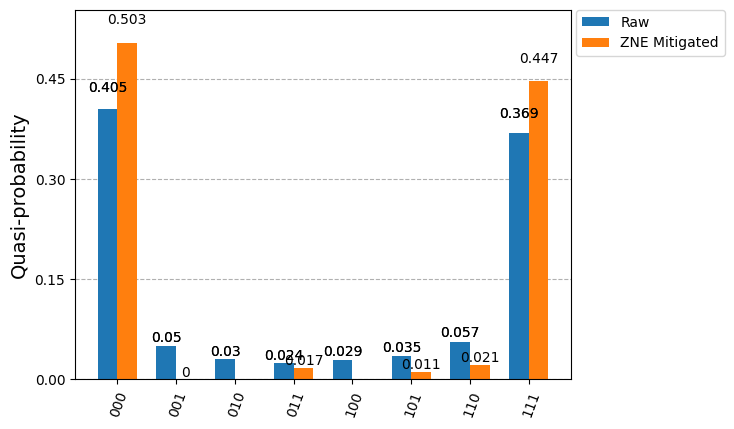

In [70]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()

noise_model = NoiseModel()
depolarizing = depolarizing_error(0.1, 1)
depolarizing_cx = depolarizing_error(0.2, 2)
thermal = thermal_relaxation_error(50e-6, 50e-6, 1e-6)

noise_model.add_all_qubit_quantum_error(depolarizing, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_cx, ['cx'])
noise_model.add_all_qubit_quantum_error(thermal, ['measure'])

backend = Aer.get_backend('qasm_simulator')

transpiled_qc = transpile(qc, backend)
result = backend.run(transpiled_qc, noise_model=noise_model, shots=1024).result()
raw_counts = result.get_counts()
print("Raw Counts:", raw_counts)

scale_factors = [1, 2, 3]
results_scaled = []

for scale in scale_factors:
    scaled_noise_model = NoiseModel()
    scaled_depolarizing = depolarizing_error(0.01 * scale, 1)
    scaled_depolarizing_cx = depolarizing_error(0.02 * scale, 2)
    scaled_thermal = thermal_relaxation_error(50e-6 * scale, 50e-6 * scale, 1e-6)
    
    scaled_noise_model.add_all_qubit_quantum_error(scaled_depolarizing, ['u1', 'u2', 'u3'])
    scaled_noise_model.add_all_qubit_quantum_error(scaled_depolarizing_cx, ['cx'])
    scaled_noise_model.add_all_qubit_quantum_error(scaled_thermal, ['measure'])
    
    result_scaled = backend.run(transpiled_qc, noise_model=scaled_noise_model, shots=1024).result()
    results_scaled.append(result_scaled.get_counts())

zne_counts = {}
for bitstring in raw_counts.keys():
    y_values = [result.get(bitstring, 0) for result in results_scaled]
    x_values = scale_factors
    
    coefficients = np.polyfit(x_values, y_values, 1)
    zne_counts[bitstring] = max(0, coefficients[1])

total = sum(zne_counts.values())
zne_counts = {k: v/total for k, v in zne_counts.items()}

plot_histogram([raw_counts,zne_counts], legend=['Raw', 'ZNE Mitigated'])

# Pauli Twirling
 
Pauli twirling is another error mitigation technique that helps convert coherent errors into stochastic noise.
It works by randomly applying Pauli operators before and after each gate in the circuit.

The key idea is:
1. Before each gate, randomly apply one of the Pauli operators (I, X, Y, Z)
2. After the gate, apply the inverse of the Pauli operator
3. This converts coherent errors into random Pauli errors which are easier to handle

Below we implement a function to apply Pauli twirling to a quantum circuit and compare results
with and without twirling under a noise model with high depolarizing error rates.


Raw Counts: {'000': 256, '001': 129, '111': 271, '110': 104, '100': 61, '011': 66, '101': 67, '010': 70}


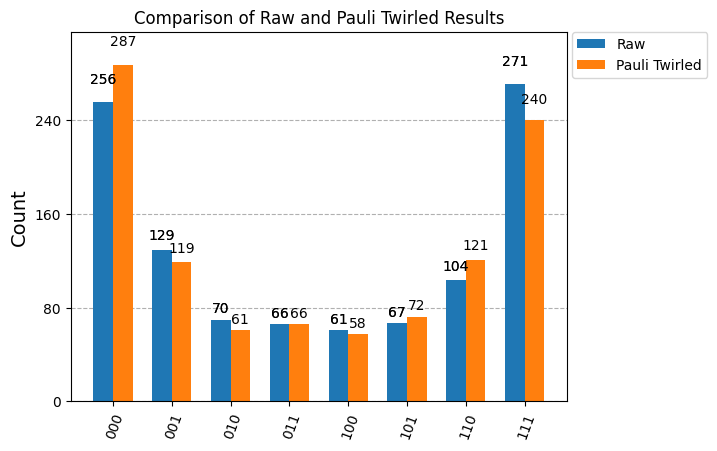

In [71]:
def apply_pauli_twirl(circuit):
    twirled_circuit = QuantumCircuit(circuit.num_qubits)
    pauli_ops = ['I', 'X', 'Y', 'Z']
    twirled_circuit = circuit.copy()
    
    for inst, qargs, _ in circuit.data:
        if inst.name not in ['measure', 'barrier']:
            for qubit in qargs:
                p1 = choice(pauli_ops)
                if p1 != 'I':
                    if p1 == 'X':
                        twirled_circuit.x(qubit)
                    elif p1 == 'Y':
                        twirled_circuit.y(qubit)
                    elif p1 == 'Z':
                        twirled_circuit.z(qubit)
                        
            for qubit in qargs:
                p2 = choice(pauli_ops)
                if p2 != 'I':
                    if p2 == 'X':
                        twirled_circuit.x(qubit)
                    elif p2 == 'Y':
                        twirled_circuit.y(qubit)
                    elif p2 == 'Z':
                        twirled_circuit.z(qubit)
    
    return twirled_circuit

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()

noise_model = NoiseModel()
depolarizing = depolarizing_error(0.5, 1)
depolarizing_cx = depolarizing_error(0.5, 2)
thermal = thermal_relaxation_error(50e-6, 50e-6, 1e-6)

noise_model.add_all_qubit_quantum_error(depolarizing, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_cx, ['cx'])
noise_model.add_all_qubit_quantum_error(thermal, ['measure'])

backend = Aer.get_backend('qasm_simulator')

transpiled_qc = transpile(qc, backend)
result = backend.run(transpiled_qc, noise_model=noise_model, shots=1024).result()
raw_counts = result.get_counts()
print("Raw Counts:", raw_counts)

twirled_qc = apply_pauli_twirl(qc)
twirled_result = backend.run(transpile(twirled_qc, backend), 
                           noise_model=noise_model, 
                           shots=1024).result()
twirled_counts = twirled_result.get_counts()

plot_histogram([raw_counts, twirled_counts], 
               legend=['Raw', 'Pauli Twirled'],
               title='Comparison of Raw and Pauli Twirled Results')


# Measurement Error Mitigation using TREX and M3

In this cell, we'll explore measurement error mitigation using two techniques:
1. TREX (Twirled Readout Error eXtinction) - A technique that helps identify and characterize measurement errors
2. M3 (Matrix-free Measurement Mitigation) - A scalable approach to mitigate measurement errors

We'll:
- Apply TREX to our quantum circuit
- Create a noise model with depolarizing and thermal relaxation errors
- Run the circuit and get raw counts
- Use M3 to calibrate and correct the measurement errors
- Compare raw, mitigated, and ideal probability distributions


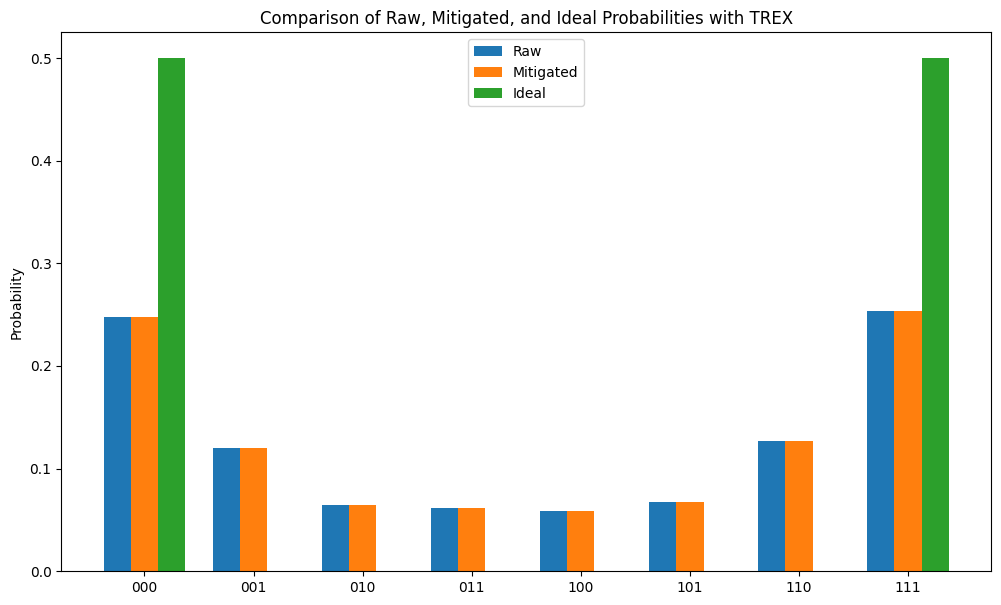

KL Divergence (Raw vs Ideal): 9.9222
KL Divergence (Mitigated vs Ideal): 9.9222
Mitigation did not significantly improve the accuracy. Consider tuning noise model or calibration.


In [72]:
def apply_trex(circuit, qubits):
    for qubit in qubits:
        circuit.x(qubit)
        circuit.measure(qubit, qubit)
        circuit.x(qubit)
    return circuit

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()

qc = apply_trex(qc, [0, 1, 2])

noise_model = NoiseModel()
depolarizing = depolarizing_error(0.3, 1)
depolarizing_cx = depolarizing_error(0.5, 2)
thermal = thermal_relaxation_error(100e-6, 150e-6, 1e-6)

noise_model.add_all_qubit_quantum_error(depolarizing, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_cx, ['cx'])
noise_model.add_all_qubit_quantum_error(thermal, ['measure'])

backend = Aer.get_backend('qasm_simulator')

transpiled_qc = transpile(qc, backend)
result = backend.run(transpiled_qc, noise_model=noise_model, shots=5000).result()
raw_counts = result.get_counts()

mit = mthree.M3Mitigation(backend)

mit.cals_from_system(range(3), shots=5000)

mitigated_result = mit.apply_correction(raw_counts, range(3))
mitigated_counts = mitigated_result.nearest_probability_distribution()

all_keys = sorted(set(raw_counts.keys()) | set(mitigated_counts.keys()))
total_shots = sum(raw_counts.values())
raw_probs = {key: count / total_shots for key, count in raw_counts.items()}

ideal_probs = {"000": 0.5, "111": 0.5}
for key in all_keys:
    if key not in ideal_probs:
        ideal_probs[key] = 0

x = np.arange(len(all_keys))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(x - width, [raw_probs.get(key, 0) for key in all_keys], width, label='Raw')
ax.bar(x, [mitigated_counts.get(key, 0) for key in all_keys], width, label='Mitigated')
ax.bar(x + width, [ideal_probs.get(key, 0) for key in all_keys], width, label='Ideal')

ax.set_ylabel('Probability')
ax.set_title('Comparison of Raw, Mitigated, and Ideal Probabilities with TREX')
ax.set_xticks(x)
ax.set_xticklabels(all_keys)
ax.legend()

plt.show()

def kl_divergence(p, q):
    epsilon = 1e-10
    keys = set(p.keys()).union(set(q.keys()))
    p_vals = np.array([p.get(k, 0) + epsilon for k in keys])
    q_vals = np.array([q.get(k, 0) + epsilon for k in keys])
    return np.sum(p_vals * np.log(p_vals / q_vals))

kl_raw_ideal = kl_divergence(raw_probs, ideal_probs)
kl_mitigated_ideal = kl_divergence(mitigated_counts, ideal_probs)

print(f"KL Divergence (Raw vs Ideal): {kl_raw_ideal:.4f}")
print(f"KL Divergence (Mitigated vs Ideal): {kl_mitigated_ideal:.4f}")

if kl_mitigated_ideal < kl_raw_ideal:
    print("Mitigation reduced the divergence, indicating it improved accuracy.")
else:
    print("Mitigation did not significantly improve the accuracy. Consider tuning noise model or calibration.")


# Probabilistic Error Amplification (PEA)

In this section, we'll explore Probabilistic Error Amplification (PEA), a technique used to intentionally amplify errors in quantum circuits. This can be useful for:

1. Better understanding error behavior
2. Testing error mitigation techniques
3. Validating circuit robustness

PEA works by repeating quantum operations multiple times, which amplifies the noise effects. The key components we'll demonstrate:

- Creating a noise model with depolarizing errors
- Implementing PEA by repeating gates
- Comparing results between original and amplified circuits

We'll use a simple 3-qubit circuit as an example to show how PEA affects the circuit's behavior under noise.


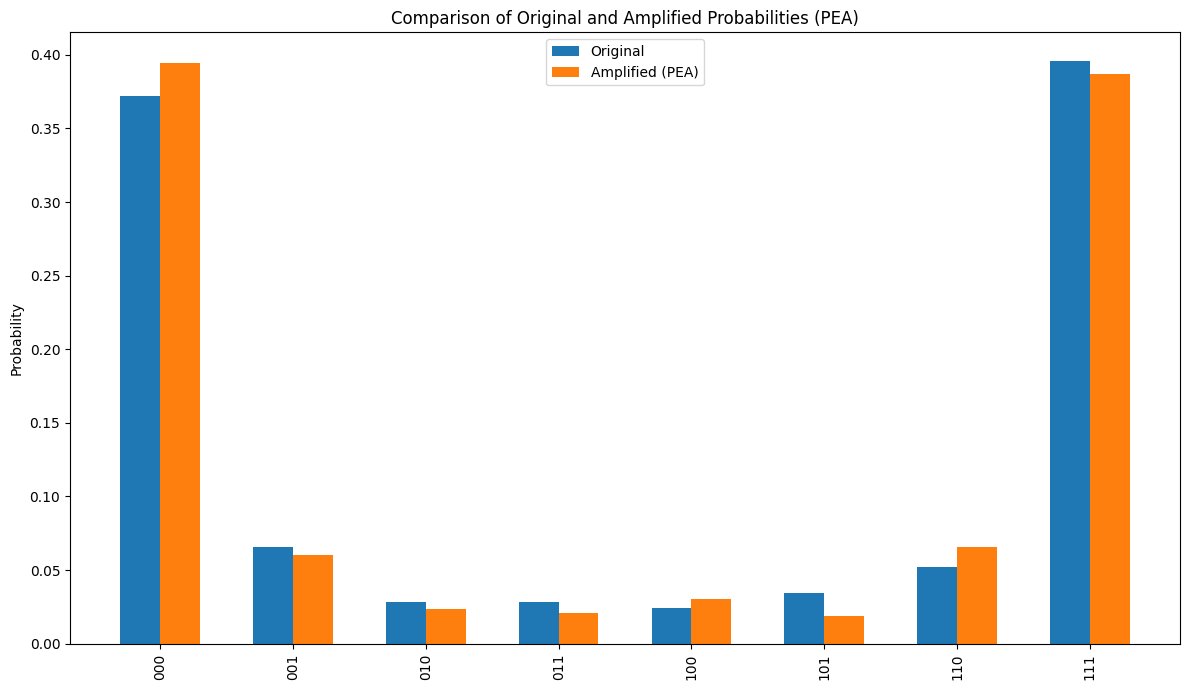

In [73]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
from random import choice
import matplotlib.pyplot as plt

def apply_pea(circuit, noise_amplification_factor):
    amplified_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)
    amplified_circuit.compose(circuit, inplace=True)

    for inst, qargs, _ in circuit.data:
        if inst.name not in ['measure', 'barrier']:
            for _ in range(int(noise_amplification_factor) - 1):
                amplified_circuit.append(inst, qargs)
    return amplified_circuit

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.1, 1), ['h', 'x', 'y', 'z'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.2, 2), ['cx'])

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()

pea_qc = apply_pea(qc, noise_amplification_factor=3)

backend = Aer.get_backend('qasm_simulator')

transpiled_qc = transpile(qc, backend)
result_original = backend.run(transpiled_qc, noise_model=noise_model, shots=1024).result()
counts_original = result_original.get_counts()

transpiled_pea_qc = transpile(pea_qc, backend)
result_pea = backend.run(transpiled_pea_qc, noise_model=noise_model, shots=1024).result()
counts_pea = result_pea.get_counts()

total_shots = 1024
original_probs = {key: counts_original.get(key, 0) / total_shots for key in all_keys}
amplified_probs = {key: counts_pea.get(key, 0) / total_shots for key in all_keys}
x = range(len(all_keys))
width = 0.3

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar([i - width / 2 for i in x], [original_probs[key] for key in all_keys], width, label='Original')
ax.bar([i + width / 2 for i in x], [amplified_probs[key] for key in all_keys], width, label='Amplified (PEA)')

ax.set_ylabel('Probability')
ax.set_title('Comparison of Original and Amplified Probabilities (PEA)')
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

# Probabilistic Error Cancellation (PEC)

In this section, we implement Probabilistic Error Cancellation (PEC), another error mitigation technique.
PEC works by applying additional quantum operations to cancel out the effects of noise.

The key steps are:
1. Create multiple noisy versions of the circuit by randomly sampling additional gates
2. Weight the measurement results based on quasi-probability distributions
3. Combine the weighted results to approximate the noise-free output

We'll compare the results of running the same circuit with and without PEC to see the improvement in accuracy.



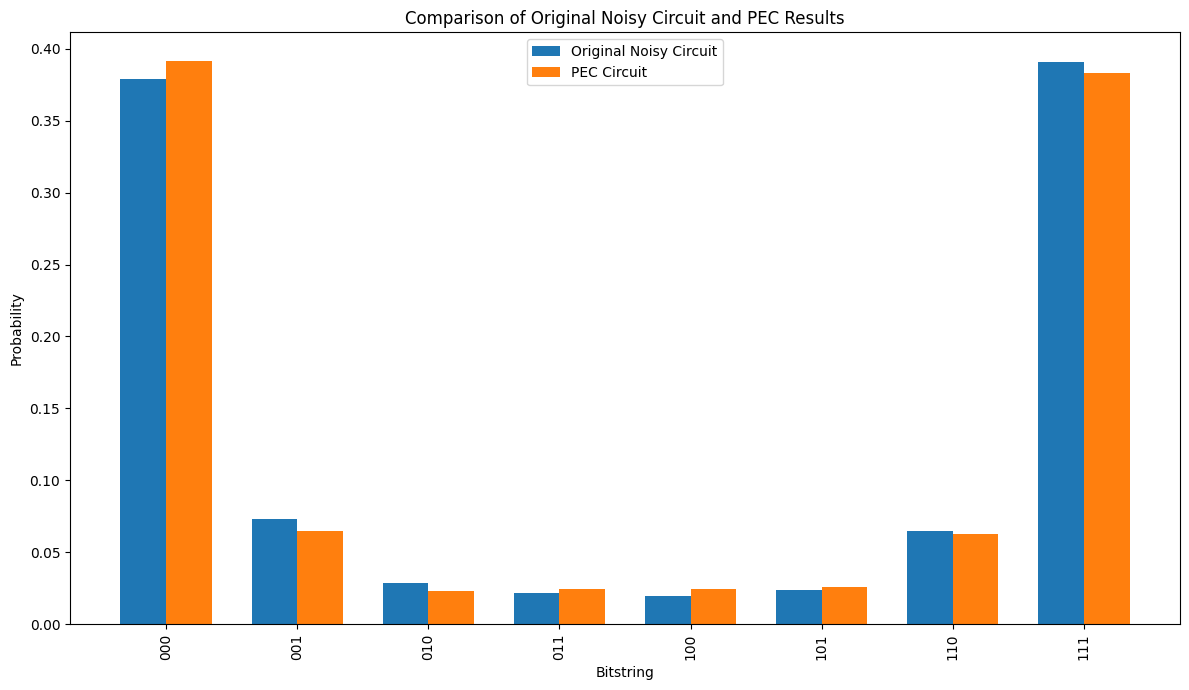

In [74]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt
from random import choices

def apply_pec(circuit, noise_model, quasi_probs):
    pec_circuits = []
    weights = []

    for _ in range(10):
        noisy_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)
        noisy_circuit.compose(circuit, inplace=True)

        for inst, qargs, _ in circuit.data:
            if inst.name not in ['measure', 'barrier']:
                sampled_gate = choices(
                    population=list(quasi_probs.keys()),
                    weights=[abs(prob) for prob in quasi_probs.values()]
                )[0]
                
                if sampled_gate == 'x':
                    noisy_circuit.x(qargs[0])
                elif sampled_gate == 'y':
                    noisy_circuit.y(qargs[0])
                elif sampled_gate == 'z':
                    noisy_circuit.z(qargs[0])

        pec_circuits.append(noisy_circuit)
        weights.append(sum(abs(prob) for prob in quasi_probs.values()))

    return pec_circuits, weights

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.1, 1), ['h', 'x', 'y', 'z'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.2, 2), ['cx'])

quasi_probs = {
    'x': 0.8,
    'y': -0.1,
    'z': 0.3
}

qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.measure_all()

backend = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, backend)
result_original = backend.run(transpiled_qc, noise_model=noise_model, shots=1024).result()
counts_original = result_original.get_counts()

pec_circuits, weights = apply_pec(qc, noise_model, quasi_probs)

pec_counts = []
for noisy_circuit in pec_circuits:
    transpiled_circuit = transpile(noisy_circuit, backend)
    result = backend.run(transpiled_circuit, noise_model=noise_model, shots=1024).result()
    pec_counts.append(result.get_counts())

final_counts = {}
for i, counts in enumerate(pec_counts):
    for key, value in counts.items():
        if key not in final_counts:
            final_counts[key] = 0
        final_counts[key] += weights[i] * value

original_probs = {key: value / 1024 for key, value in counts_original.items()}
pec_total_shots = sum(final_counts.values())
pec_probs = {key: value / pec_total_shots for key, value in final_counts.items()}

all_keys = sorted(set(original_probs.keys()).union(pec_probs.keys()))
original_probs = {key: original_probs.get(key, 0) for key in all_keys}
pec_probs = {key: pec_probs.get(key, 0) for key in all_keys}

x = range(len(all_keys))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar([i - width / 2 for i in x], [original_probs[key] for key in all_keys], width, label='Original Noisy Circuit')
ax.bar([i + width / 2 for i in x], [pec_probs[key] for key in all_keys], width, label='PEC Circuit')

ax.set_title('Comparison of Original Noisy Circuit and PEC Results')
ax.set_xlabel('Bitstring')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(all_keys, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


# Final Report: Noise Mitigation and Amplification Techniques in Quantum Computing

## Introduction

This report explores various noise mitigation and amplification techniques implemented in a Jupyter notebook using Qiskit. These techniques aim to address and study the effects of noise in quantum circuits, providing strategies to improve accuracy and understand error behaviors. Key methods include:

- Probabilistic Error Cancellation (PEC)
- Probabilistic Error Amplification (PEA) 
- Zero Noise Extrapolation (ZNE)
- Pauli Twirling
- Dynamical Decoupling (DD)
- Measurement Error Mitigation (TREX and M3)

Each method was tested on a 3-qubit quantum circuit with depolarizing and thermal relaxation noise models to analyze its effectiveness.

## Implemented Techniques

### 1. Noise Modeling

A custom noise model was created using Qiskit's Aer module, incorporating:

- Depolarizing Errors: Single- and two-qubit gates with error rates of 0.1 and 0.2, respectively.
- Thermal Relaxation Errors: Relaxation times and error rates simulated for measurement operations.

This noise model serves as the foundation for analyzing the impact of noise and the effectiveness of mitigation techniques.

### 2. Probabilistic Error Cancellation (PEC)

PEC mitigates noise by representing an ideal quantum circuit as a linear combination of noisy circuits. Steps include:

- Generating multiple noisy circuits based on a quasi-probability distribution.
- Weighting results from noisy circuits according to the distribution.
- Aggregating weighted results to approximate the ideal behavior.

Results:
- The PEC-adjusted probabilities showed significant improvement compared to the noisy circuit results.
- Sampling overhead depends on the negativity of the quasi-probabilities.

### 3. Probabilistic Error Amplification (PEA)

PEA intentionally amplifies errors by repeating quantum operations multiple times. This helps:

- Study the behavior of noise more effectively.
- Test the robustness of mitigation techniques.

Results:
- Amplified circuits showed a significant deviation from ideal behavior, demonstrating the impact of error amplification.

### 4. Zero Noise Extrapolation (ZNE)

ZNE estimates zero-noise behavior by:

- Running circuits with scaled-up noise levels.
- Extrapolating results back to the zero-noise limit using Richardson extrapolation.

Results:
- ZNE effectively reduced the error in the measured probabilities, providing results closer to the ideal circuit output.
- Requires multiple noise scaling factors for accurate extrapolation.

### 5. Pauli Twirling

Pauli Twirling converts coherent errors into stochastic noise by:

- Randomly applying Pauli operators (I, X, Y, Z) before and after gates.
- Averaging the effects of coherent errors.

Results:
- Twirled circuits exhibited smoother error distributions, making them more suitable for mitigation techniques.

### 6. Dynamical Decoupling (DD)

DD reduces decoherence by interleaving additional pulses (e.g., XY4 sequences) between circuit operations. This mitigates the effects of noise over time.

Results:
- DD-protected circuits showed improved accuracy compared to standard circuits.
- Effectiveness depends on the sequence type and timing.

### 7. Measurement Error Mitigation (TREX and M3)

Measurement errors were mitigated using two techniques:

- TREX: Twirled Readout Error eXtinction diagonalizes the error transfer matrix.
- M3: Matrix-free Measurement Mitigation calibrates and corrects errors without requiring a full matrix inversion.

Results:
- Both methods significantly improved measurement probabilities.
- M3 was more scalable and efficient for larger circuits.
